<a href="https://colab.research.google.com/github/Dagobert42/WinProbabilityModel-AoE2/blob/main/WinProbabilityModel_AoE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Non-Linear Win Probability Model for Age of Empires II

- Age of Empires II ["AoE2"] is a real-time strategy game set in the middle-ages
- players build a base and command units with the goal of defeating each other 

**Hypothesis:** map and civilisation have non-linear influence on the initial win probabilities of a match

**Idea:** compare predictive power of linear and non-linear models

This project conforms to Microsoft's [Game Content Usage Rules](https://www.xbox.com/en-us/developers/rules).

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Introduction

- players are rated in Elo-system (similar to Chess)
- ratings can be converted directly into probability distributions for the outcome of a match between players A and B by:

$$wp_{A} = \frac{1}{1+10 ^{(r_{A} - r_{B}) / t)}}$$

TODO: cite wikipedia

In [16]:
TRANSFER = 200
def elo_to_win_prob(r_player, r_opponent):
    return 1 / ( 1 + 10**((r_opponent - r_player) / TRANSFER))

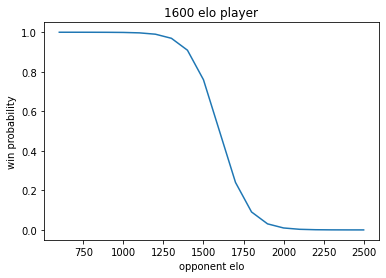

In [78]:
player = 1600
opponents = range(600, 2600, 100)
probs = []
for o in opponents:
    probs.append(elo_to_win_prob(player, float(o)))
plt.plot(opponents, probs)
plt.ylabel('win probability')
plt.xlabel('opponent elo')
plt.title('1600 elo player')
plt.show()

## 2. Data Preprocessing

The following section is included for purposes of the presentation. 

Preprocessing has **already been done** and the resulting csv is provided from the corresponding github repository.

### 1.1 Processing **matches**

-   limit to 1v1 matches
-   pick a patch (balance changes occur with patches)
-   drop unneeded columns

In [18]:
matches = pd.read_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/matches.csv')

matches = matches.loc[matches['ladder'] == 'RM_1v1']
matches['patch'].value_counts()

37906    430742
39515    261010
36906    249256
36202    242339
43210    237932
40220    222052
40874    202466
41855    196138
35584     97815
39284      5936
37650      4909
42848      2067
Name: patch, dtype: int64

In [19]:
matches = matches.loc[matches['patch'] == 43210] # most recent patch
matches = matches.drop(columns=['patch', 'ladder', 'mirror', 'average_rating', 'map_size', 'num_players', 'server', 'duration'])
matches.info()
matches['winning_team'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237932 entries, 44 to 3153755
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   token         237932 non-null  object
 1   winning_team  237932 non-null  int64 
 2   map           237932 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.3+ MB


 2    119517
 1    118408
-1         7
Name: winning_team, dtype: int64

### 1.2 Processing **players**

- remove players with invalid team value (-1)
- remove matches with invalid teams
- keep only players that were in matches
- drop unneeded columns

In [20]:
players = pd.read_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/match_players.csv')

invalid_players = players.loc[players['team'] == -1]
matches = matches.loc[~matches['token'].isin(invalid_players['match'])]

players = players.loc[players['match'].isin(matches['token'])]
players = players.drop(columns=['token', 'color', 'winner'])
players.info()
players['team'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475206 entries, 28 to 9732493
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   match   475206 non-null  object 
 1   rating  463297 non-null  float64
 2   civ     475206 non-null  object 
 3   team    475206 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 18.1+ MB


2    237605
1    237601
Name: team, dtype: int64

### 1.3 Merging

- merge matches and players into one dataframe
- exclude players with invalid team (encodes the winner)

This took a very long time (about 3 hours).

In [21]:
#TODO: !npx degit Dagobert42/WinProbabilityModel-AoE2/match_data -f

In [22]:
try:
    matches_1v1 = pd.read_csv('matches_1v1.csv')
except:
    matches_1v1 = pd.DataFrame(columns=['match_id', 'map', 'rating_p1', 'civ_p1', 'rating_p2', 'civ_p2'])

    player_dict = players.to_dict('records')

    SAVE_EVERY = 50000
    invalid_matches = 0
    count = 0
    for match in tqdm(matches.to_dict('records')):
        p1 = None
        p2 = None
        for i, player in enumerate(player_dict):
            if player['match'] == match['token']:
                if player['team'] == 1:
                    p1 = player
                    p1_i = i
                elif player['team'] == 2:
                    p2 = player
                    p2_i = i
            # remove already assigned players
            # increase speed gradually
            if p1 and p2:
                if p1_i < p2_i:
                    player_dict.pop(p2_i)
                    player_dict.pop(p1_i)
                else:
                    player_dict.pop(p1_i)
                    player_dict.pop(p2_i)
                break

        if not p1 or not p2:
            invalid_matches += 1
            continue
        else:
            entry = {
                'match_id' : match['token'],
                'map' : match['map'],
                'rating_p1' : p1['rating'],
                'civ_p1' : p1['civ'],
                'rating_p2' : p2['rating'],
                'civ_p2' : p2['civ'],
                'winner' : match['winning_team']
            }
            matches_1v1 = matches_1v1.append(entry, ignore_index=True)

        if count % SAVE_EVERY == 0:
            matches_1v1.to_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/matches_1v1_' + str(count) + '.csv', index=False)
        count += 1
        
    print(invalid_matches, 'matches excluded (at least one player unidentifiable)')
    # save the result!
    matches_1v1.to_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/matches_1v1.csv', index=False)

**Question for later:** Is deleting players faster in Big O?

$O(\sum_{i=1}^{m} n-2i)$
$= O(n-2 + n-4 + ... + n-2m)$

Which would still be
$O(m*n)$ ?

Or would it be $O(n)$ since $m = 2n$?


In [23]:
matches_1v1.info()
matches_1v1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140001 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   140001 non-null  object 
 1   map        140001 non-null  object 
 2   rating_p1  136460 non-null  float64
 3   civ_p1     140001 non-null  object 
 4   rating_p2  136653 non-null  float64
 5   civ_p2     140001 non-null  object 
 6   winner     140001 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.5+ MB


,match_id,map,rating_p1,civ_p1,rating_p2,civ_p2,winner
0,DdP54WQtNdE0VcwM,migration,1343.0,Vikings,1332.0,Malay,1.0
1,ChnySMotXQbBOEBm,serengeti,1300.0,Burmese,1300.0,Franks,2.0
2,2gxTqXARRJB7wX3m,arabia,1277.0,Franks,1291.0,Vietnamese,1.0
3,JiobK4iAfpqwnc65,arabia,1161.0,Chinese,1168.0,Ethiopians,1.0
4,92n1BkbfROYsPb7u,arabia,1201.0,Mayans,1166.0,Vietnamese,1.0


### 1.4 Treating NaN-values (KNN)

**Problem:** some ratings are missing

In [24]:
nan_rated_players = players.loc[players['rating'].isna()]
nan_rated_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11909 entries, 7928 to 9732490
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   match   11909 non-null  object 
 1   rating  0 non-null      float64
 2   civ     11909 non-null  object 
 3   team    11909 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 465.2+ KB


In [25]:
affected_matches = matches_1v1.loc[matches_1v1['match_id'].isin(nan_rated_players['match'])]
affected_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 28 to 139967
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   match_id   6889 non-null   object 
 1   map        6889 non-null   object 
 2   rating_p1  3348 non-null   float64
 3   civ_p1     6889 non-null   object 
 4   rating_p2  3541 non-null   float64
 5   civ_p2     6889 non-null   object 
 6   winner     6889 non-null   float64
dtypes: float64(3), object(4)
memory usage: 430.6+ KB


**Option:** simply omit NaN rated players and affected matches (not chosen)

In [26]:
valid_matches = matches_1v1.loc[~matches_1v1['match_id'].isin(affected_matches['match_id'])]
valid_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133112 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   133112 non-null  object 
 1   map        133112 non-null  object 
 2   rating_p1  133112 non-null  float64
 3   civ_p1     133112 non-null  object 
 4   rating_p2  133112 non-null  float64
 5   civ_p2     133112 non-null  object 
 6   winner     133112 non-null  float64
dtypes: float64(3), object(4)
memory usage: 8.1+ MB


**Solution:** estimate NaN ratings with k-nearest-neighbor

In [65]:
from sklearn.neighbors import KNeighborsRegressor as KNR

try:
    augmented_1v1 = pd.read_csv('augmented_1v1.csv')
except:
    matches_knr = valid_matches.sample(1000)
    nan_knr = KNR(n_neighbors=5, weights="distance")

    # order of p1 and p2 is arbitrary for training
    X = matches_knr['rating_p1'].to_numpy()
    X = np.expand_dims(X, axis=1)
    y = matches_knr['rating_p2'].to_numpy()
    nan_knr.fit(X,y)

    for _, m in tqdm(affected_matches.iterrows()):
        if pd.isnull(m['rating_p1']):
            m['rating_p1'] = round(nan_knr.predict(np.array(m['rating_p2']).reshape(1, -1))[0])
        else:
            m['rating_p2'] = round(nan_knr.predict(np.array(m['rating_p1']).reshape(1, -1))[0])
        valid_matches = valid_matches.append(m)

    # save the result
    valid_matches.to_csv('augmented_1v1.csv', index=False)
    valid_matches.info()
    valid_matches.head()

Since KNR uses interpolation we overestimate low ratings and underestimate high ratings.

### 1.5 Normalization (Z-Score)

**Problem:** ratings are distributed asymmetrically

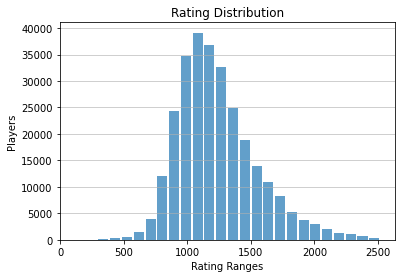

In [28]:
all_ratings = augmented_1v1['rating_p1'].append(augmented_1v1['rating_p2'])
n, bins, patches = plt.hist(x=all_ratings, bins=26, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating Ranges')
plt.ylabel('Players')
plt.title('Rating Distribution')
plt.show()

In [29]:
print('rating skew:', all_ratings.skew())

rating skew: 0.8488769209625611


**Solution:** normalize ratings considering uneven distribution (z-score)

In [96]:
try:
    normalized_1v1 = pd.read_csv('normalized_1v1.csv')
except:
    rating_mean = all_ratings.mean()
    rating_std = all_ratings.std()

    normalized_1v1 = augmented_1v1
    for i in range(len(normalized_1v1)):
        normalized_1v1.at[i, 'rating_p1'] = (augmented_1v1.at[i, 'rating_p1'] - rating_mean) / rating_std
        normalized_1v1.at[i, 'rating_p2'] = (augmented_1v1.at[i, 'rating_p2'] - rating_mean) / rating_std

    normalized_1v1.to_csv('normalized_1v1.csv', index=False)
    normalized_1v1.info()
    normalized_1v1.head()

### 1.6 One-Hot Encoding
Lastly, we also need numeric values for categorical attributes.

In [50]:
from sklearn.preprocessing import OneHotEncoder

maps_ohe = OneHotEncoder(sparse=False)
maps = maps_ohe.fit_transform(normalized_1v1['map'].values.reshape(-1, 1))

civs_ohe = OneHotEncoder(sparse=False)
civs_ohe.fit(players['civ'].values.reshape(-1, 1))

civ_p1 = civs_ohe.transform(normalized_1v1['civ_p1'].values.reshape(-1, 1))
civ_p2 = civs_ohe.transform(normalized_1v1['civ_p2'].values.reshape(-1, 1))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 2. Linear Models

Prepare data as numpy arrays

In [72]:
X = np.concatenate((
    maps,
    normalized_1v1['rating_p1'].values.reshape(-1, 1),
    civ_p1,
    normalized_1v1['rating_p2'].values.reshape(-1, 1),
    civ_p2
    ), axis=1)
y = normalized_1v1['winner'].values

In [112]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, y)
print('Lin Reg Score:', lin_reg.score(X[:10000], y[:10000]))

ridge = linear_model.Ridge()
ridge.fit(X, y)
print('Ridge Score:', ridge.score(X[:10000], y[:10000]))

bay_ridge = linear_model.BayesianRidge()
bay_ridge.fit(X, y)
print('Bayesian Ridge Score:', bay_ridge.score(X[:10000], y[:10000]))

Lin Reg Score: 0.007086050427686729
Ridge Score: 0.007084238441593228
Bayesian Ridge Score: 0.006507175308799961
